In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Washburn2019r

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp07-washburn2019r'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-values.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	}
}

# Ensure correct 
config['output']['length'] = len(tpm_order[config['output']['group0']])

In [7]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 44525822


## 2.1 Data

In [8]:
# Get the correct output group

gene_targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [9]:
# Transform the data dictionaries into lists

names = sorted(list(gene_sequences.keys()))

sequences = numpy.array([gene_sequences[key] for key in names])
features  = numpy.array([gene_frequency[key] for key in names])
targets   = numpy.array([gene_targets[key]   for key in names])

In [10]:
# Create the dataset and generte split indices using sklearn

dataset = GeneDataset(
	names       = names,
	sequences   = sequences,
	features    = features,
	targets     = targets,
	expand_dims = 0
)

train_idx, valid_idx, test_idx = cnn_dataset.generate_split_indices(
	targets     = targets,
	valid_split = config['split_size']['valid'],
	test_split  = config['split_size']['test'],
	random_seed = config['random_seed']
)

In [11]:
# Create train dataloader and display batch dimensions

train_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = train_idx,
	batch_size = config['batch_size']['train']
)

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    316
Dataloader sample count : 20,224

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [12]:
# Create valid dataloader and display batch dimensions

valid_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = valid_idx,
	batch_size = config['batch_size']['valid']
)

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     79
Dataloader sample count :  5,056

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [13]:
# Create test dataloader and display batch dimensions

test_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = test_idx,
	batch_size = config['batch_size']['test']
)

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

### 2.2.1 Structure

In [14]:
# Create and display the model structure

model = Washburn2019r(params = {
	'other' : {
		'in_channels' : config['input']['channels'],
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'kernel'  : (4, 11),
		'padding' : (0, 0)
	},
	'conv2' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv3' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv4' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv5' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'conv6' : {
		'kernel'  : (1, 11),
		'padding' : (0, 5)
	},
	'maxpool1' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'maxpool2' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'maxpool3' : {
		'kernel'  : (1, 5),
		'padding' : (0, 2)
	},
	'fc3' : {
		'features' : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_channels = config['input']['channels'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Washburn2019r                            [64, 1, 4, 2150]          [64, 8]                   --
├─Washburn2019: 1-1                      [64, 1, 4, 2150]          [64, 32]                  --
│    └─Conv2d: 2-1                       [64, 1, 4, 2150]          [64, 64, 1, 2140]         2,880
│    └─ReLU: 2-2                         [64, 64, 1, 2140]         [64, 64, 1, 2140]         --
│    └─Conv2d: 2-3                       [64, 64, 1, 2140]         [64, 64, 1, 2140]         45,120
│    └─ReLU: 2-4                         [64, 64, 1, 2140]         [64, 64, 1, 2140]         --
│    └─MaxPool2d: 2-5                    [64, 64, 1, 2140]         [64, 64, 1, 714]          --
│    └─Dropout: 2-6                      [64, 64, 1, 714]          [64, 64, 1, 714]          --
│    └─Conv2d: 2-7                       [64, 64, 1, 714]          [64, 128, 1, 714]         90,240
│    └─ReLU: 2-8        

In [15]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

### 2.2.2 Parameters

In [16]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean'
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 10,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'mse'   : cnn_model.get_criterion(reduction = 'none', query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', query = 'mae'),
		'huber' : cnn_model.get_criterion(reduction = 'none', query = 'huber'),
		'r2'    : cnn_model.get_criterion(reduction = 'none', query = 'r2')
	}
}

## 2.3 Training

In [17]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

### 2.3.1 Visualization

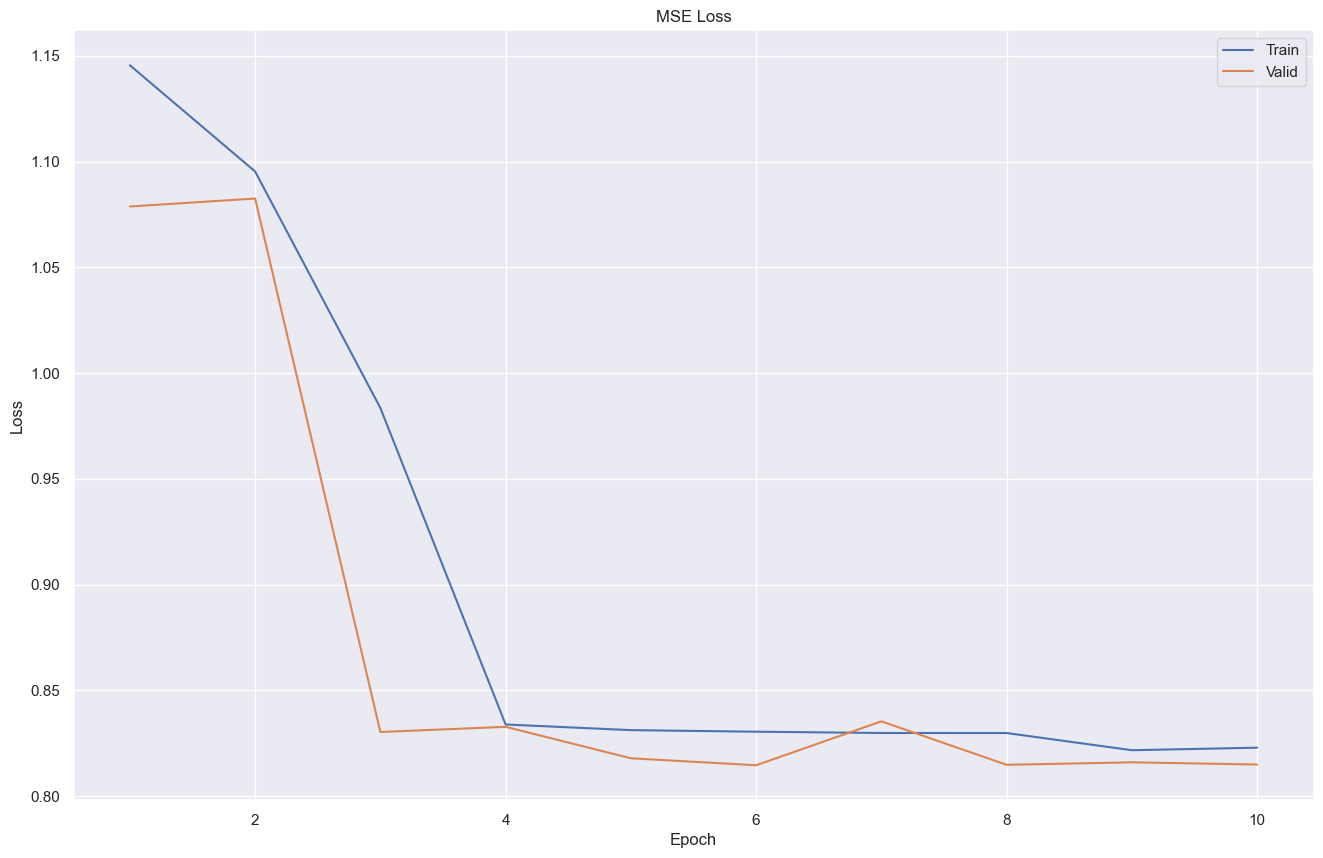

In [18]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

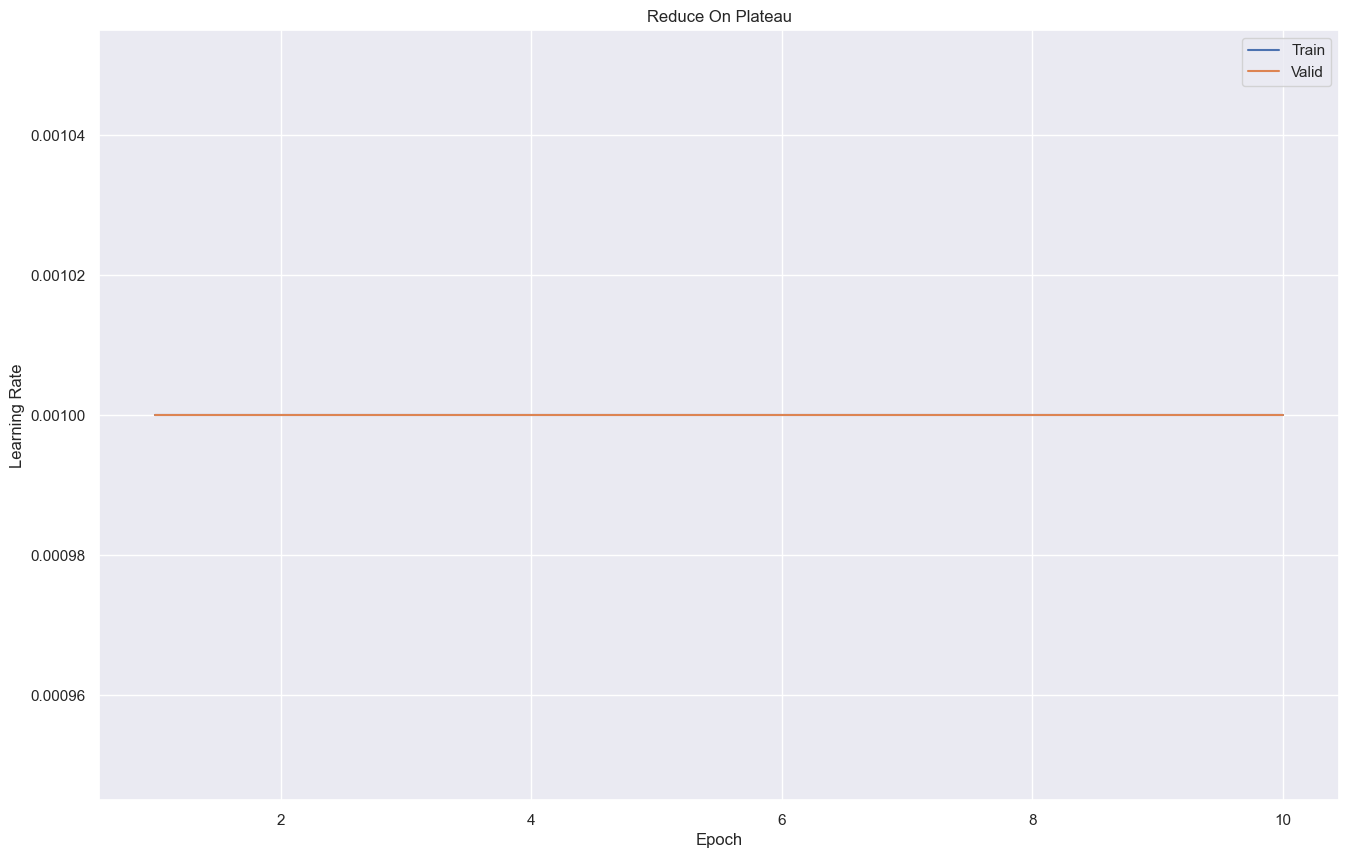

In [19]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

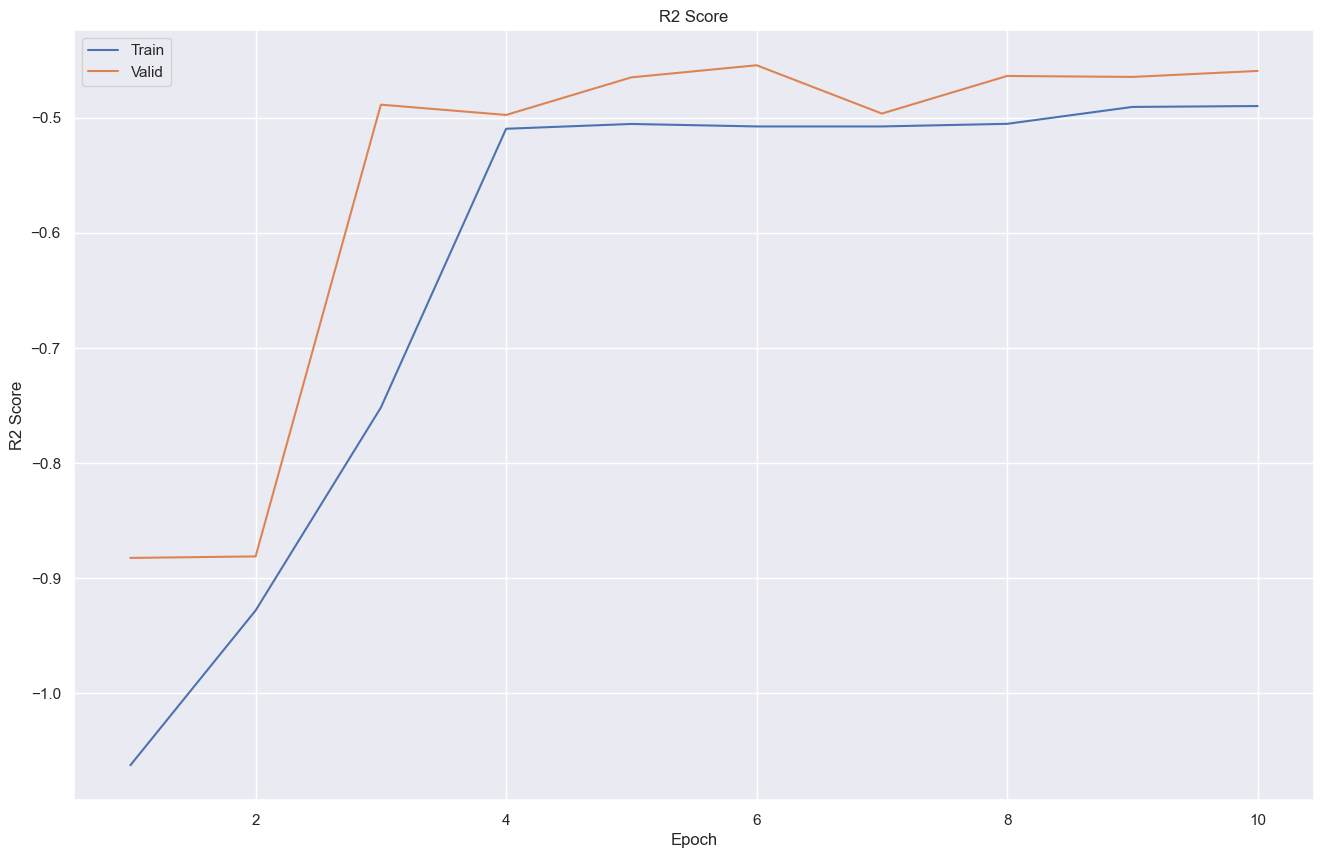

In [20]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

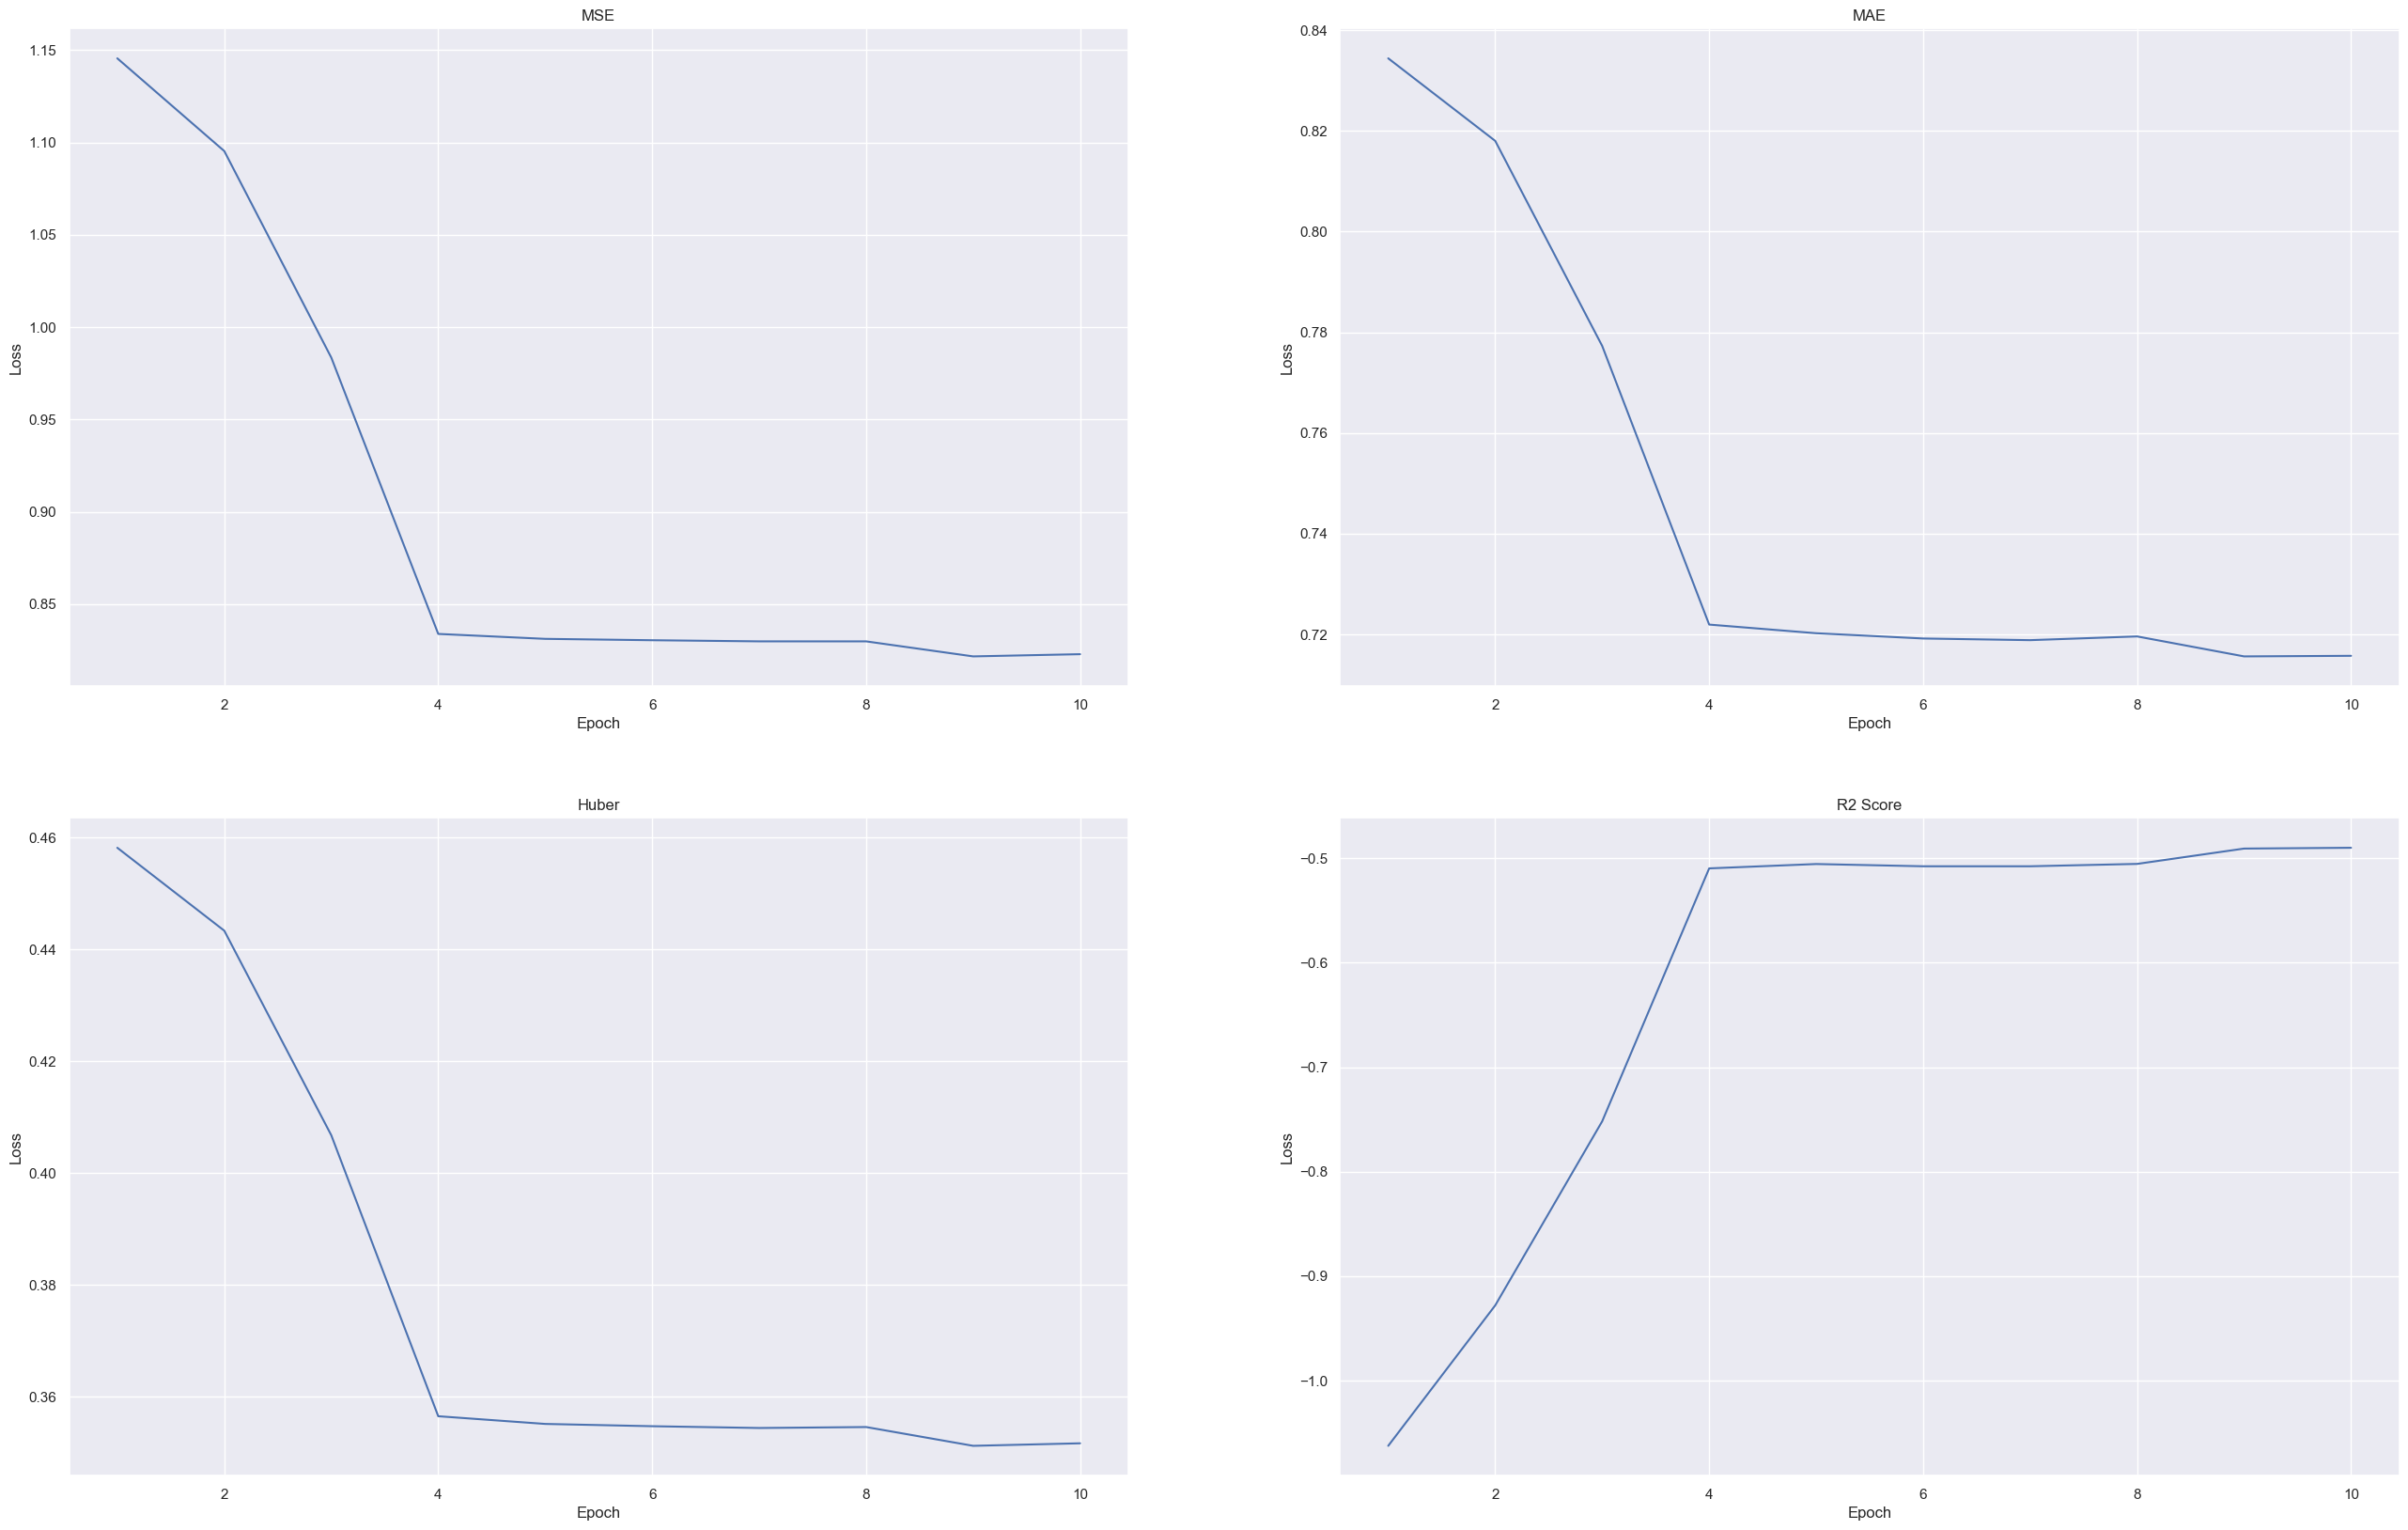

In [21]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

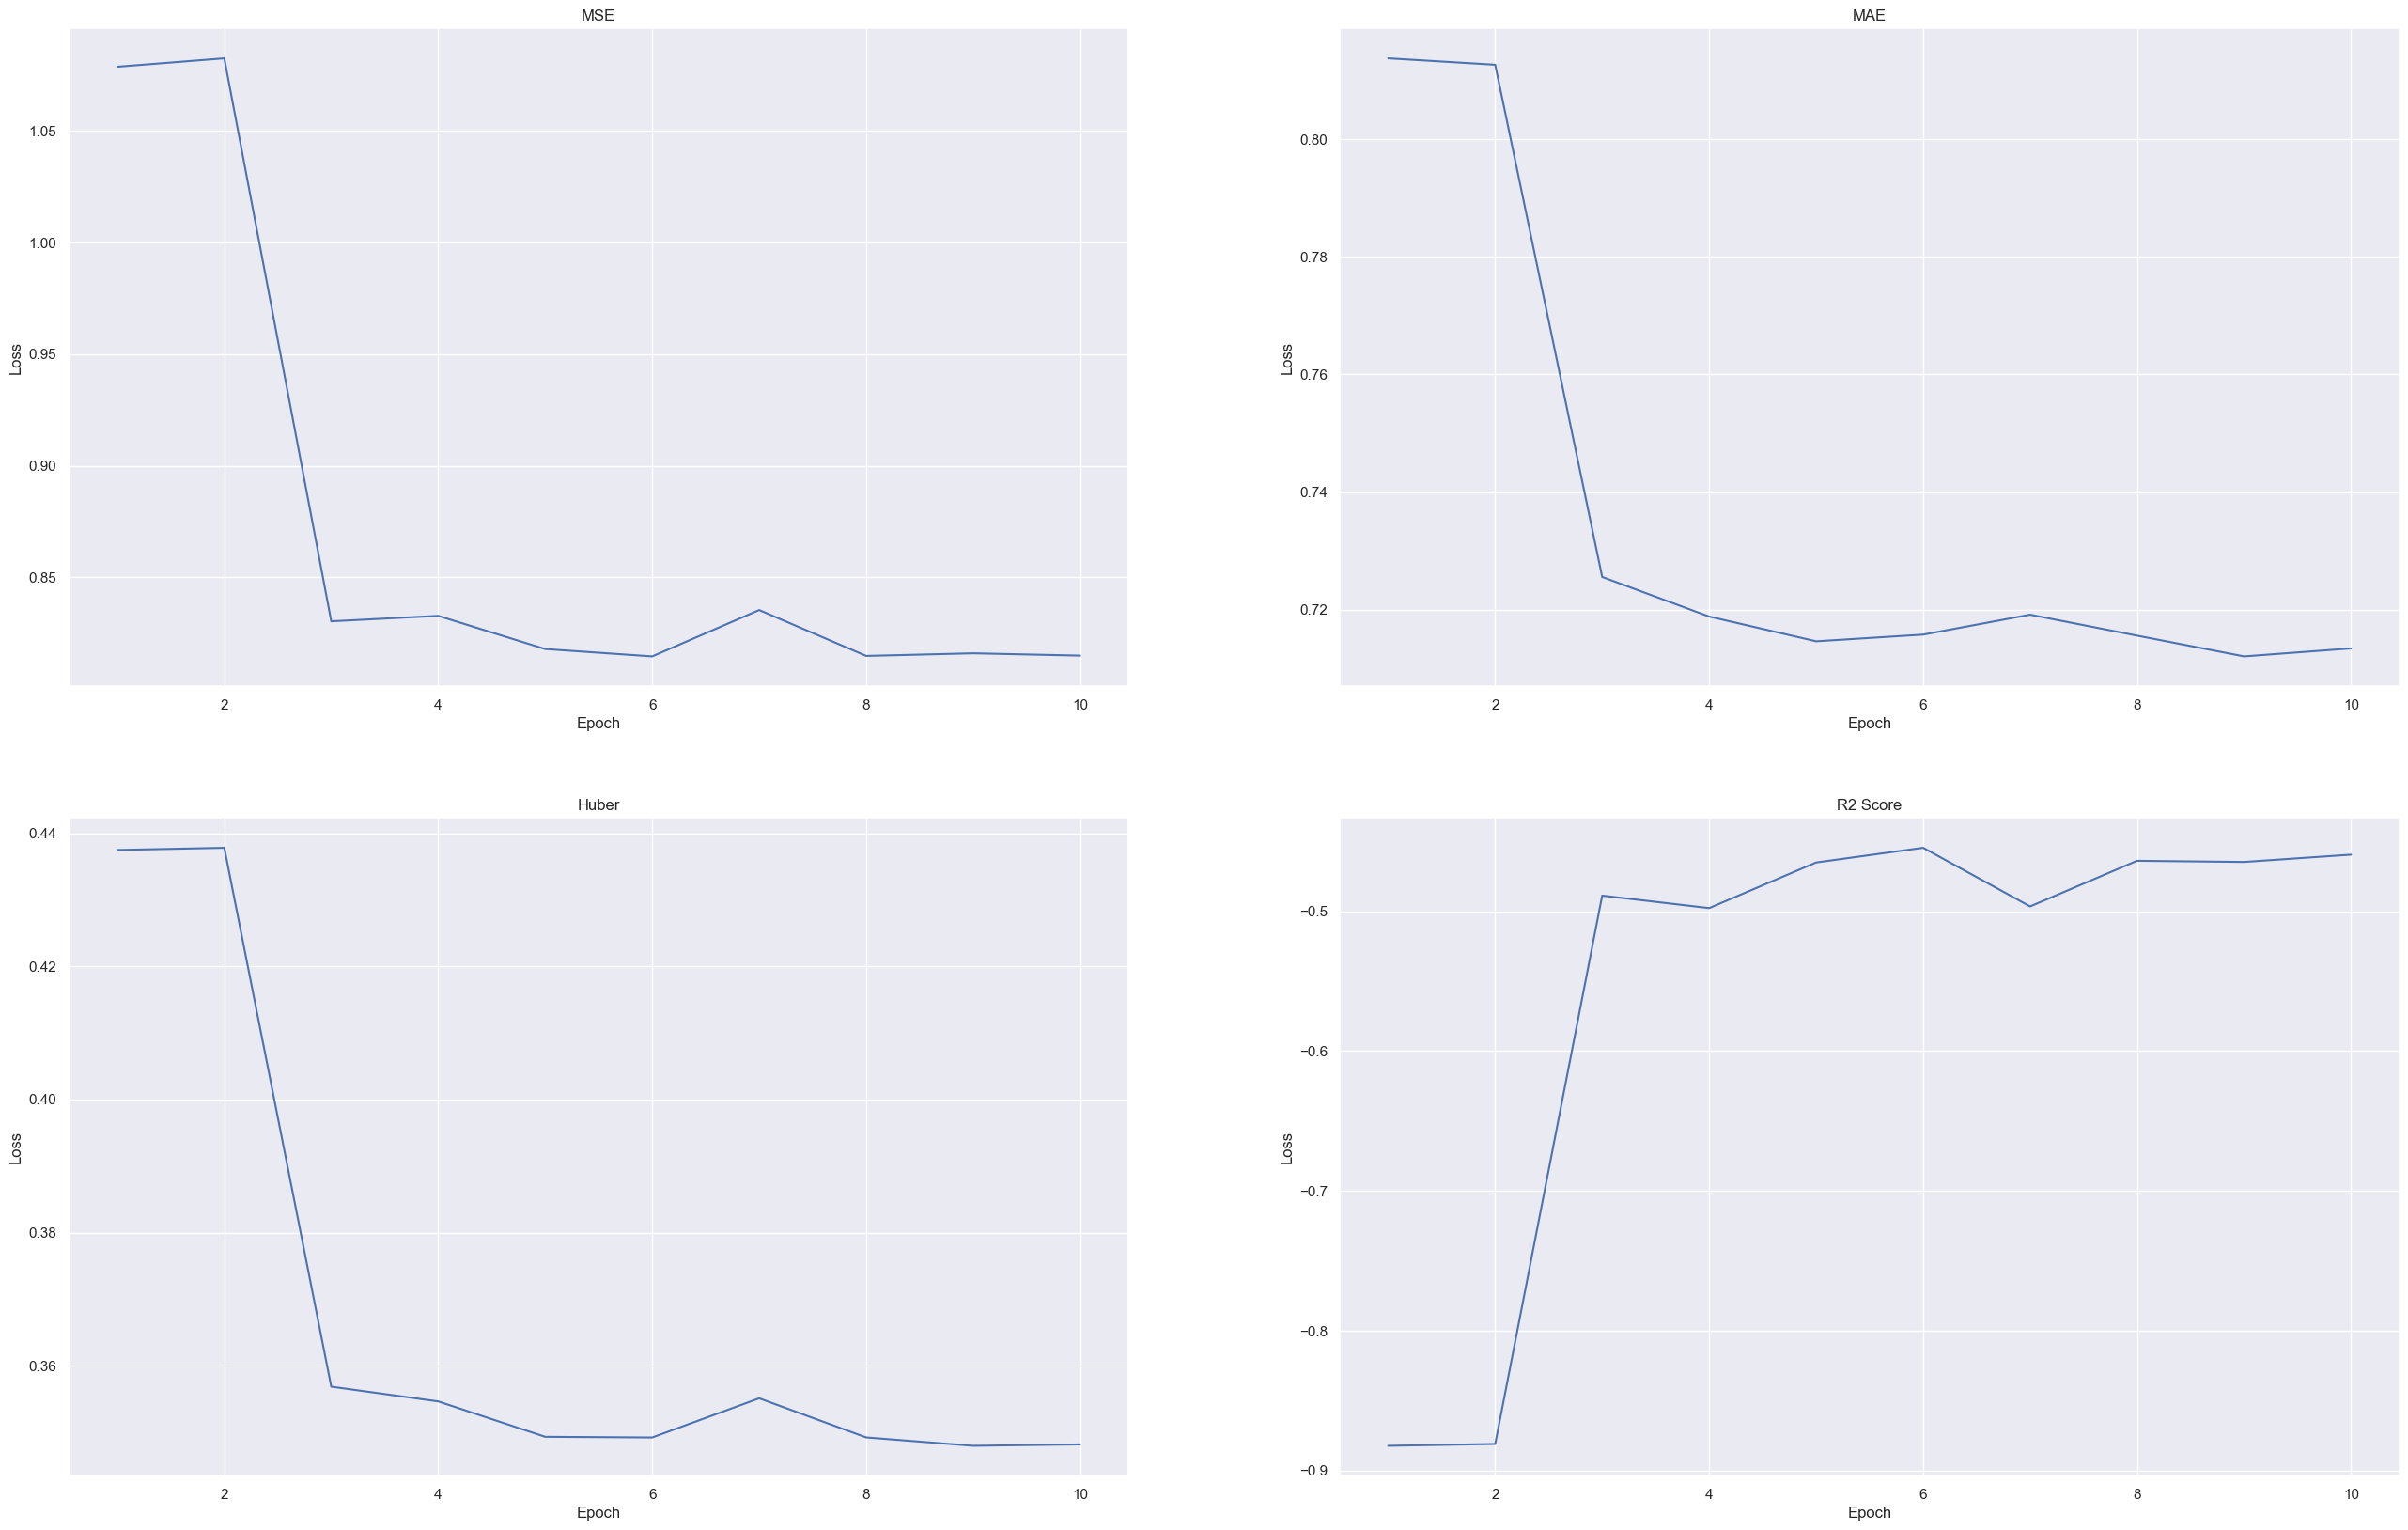

In [22]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [23]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
Loss  : 0.81499


<All keys matched successfully>

In [24]:
# Evaluate the model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [25]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.43492
MAE Loss :  0.71335
MSE Loss :  0.81064


In [26]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT2G27930.1
True : [ 0.89447    0.19712    0.64997    1.06603    0.43017    0.48359    0.01604    0.03016]
Pred : [ 0.00000    1.21366    1.22312    1.41282    1.30572    1.35672    0.99133    0.62702]
 MAE : [ 0.89447    1.01653    0.57315    0.34679    0.87556    0.87313    0.97530    0.59686]
 MSE : [ 0.80007    1.03334    0.32850    0.12027    0.76660    0.76235    0.95120    0.35625]
 R2  : [-3.88974    0.07753    0.06654    0.09317    0.11097    0.09162    0.06511    0.04979]

Gene : AT5G61520.2
True : [ 1.12827    1.08664    0.17601    0.14098    0.53542    1.16288    1.38145    0.09497]
Pred : [ 0.00000    1.00158    1.01114    1.16868    1.07510    1.12127    0.81811    0.51540]
 MAE : [ 1.12827    0.08507    0.83514    1.02770    0.53968    0.04162    0.56335    0.42042]
 MSE : [ 1.27298    0.00724    0.69745    1.05617    0.29125    0.00173    0.31736    0.17676]
 R2  : [-3.59630    0.03785   -0.00114    0.00247    0.02939    0.03195    0.02476    0.01209]



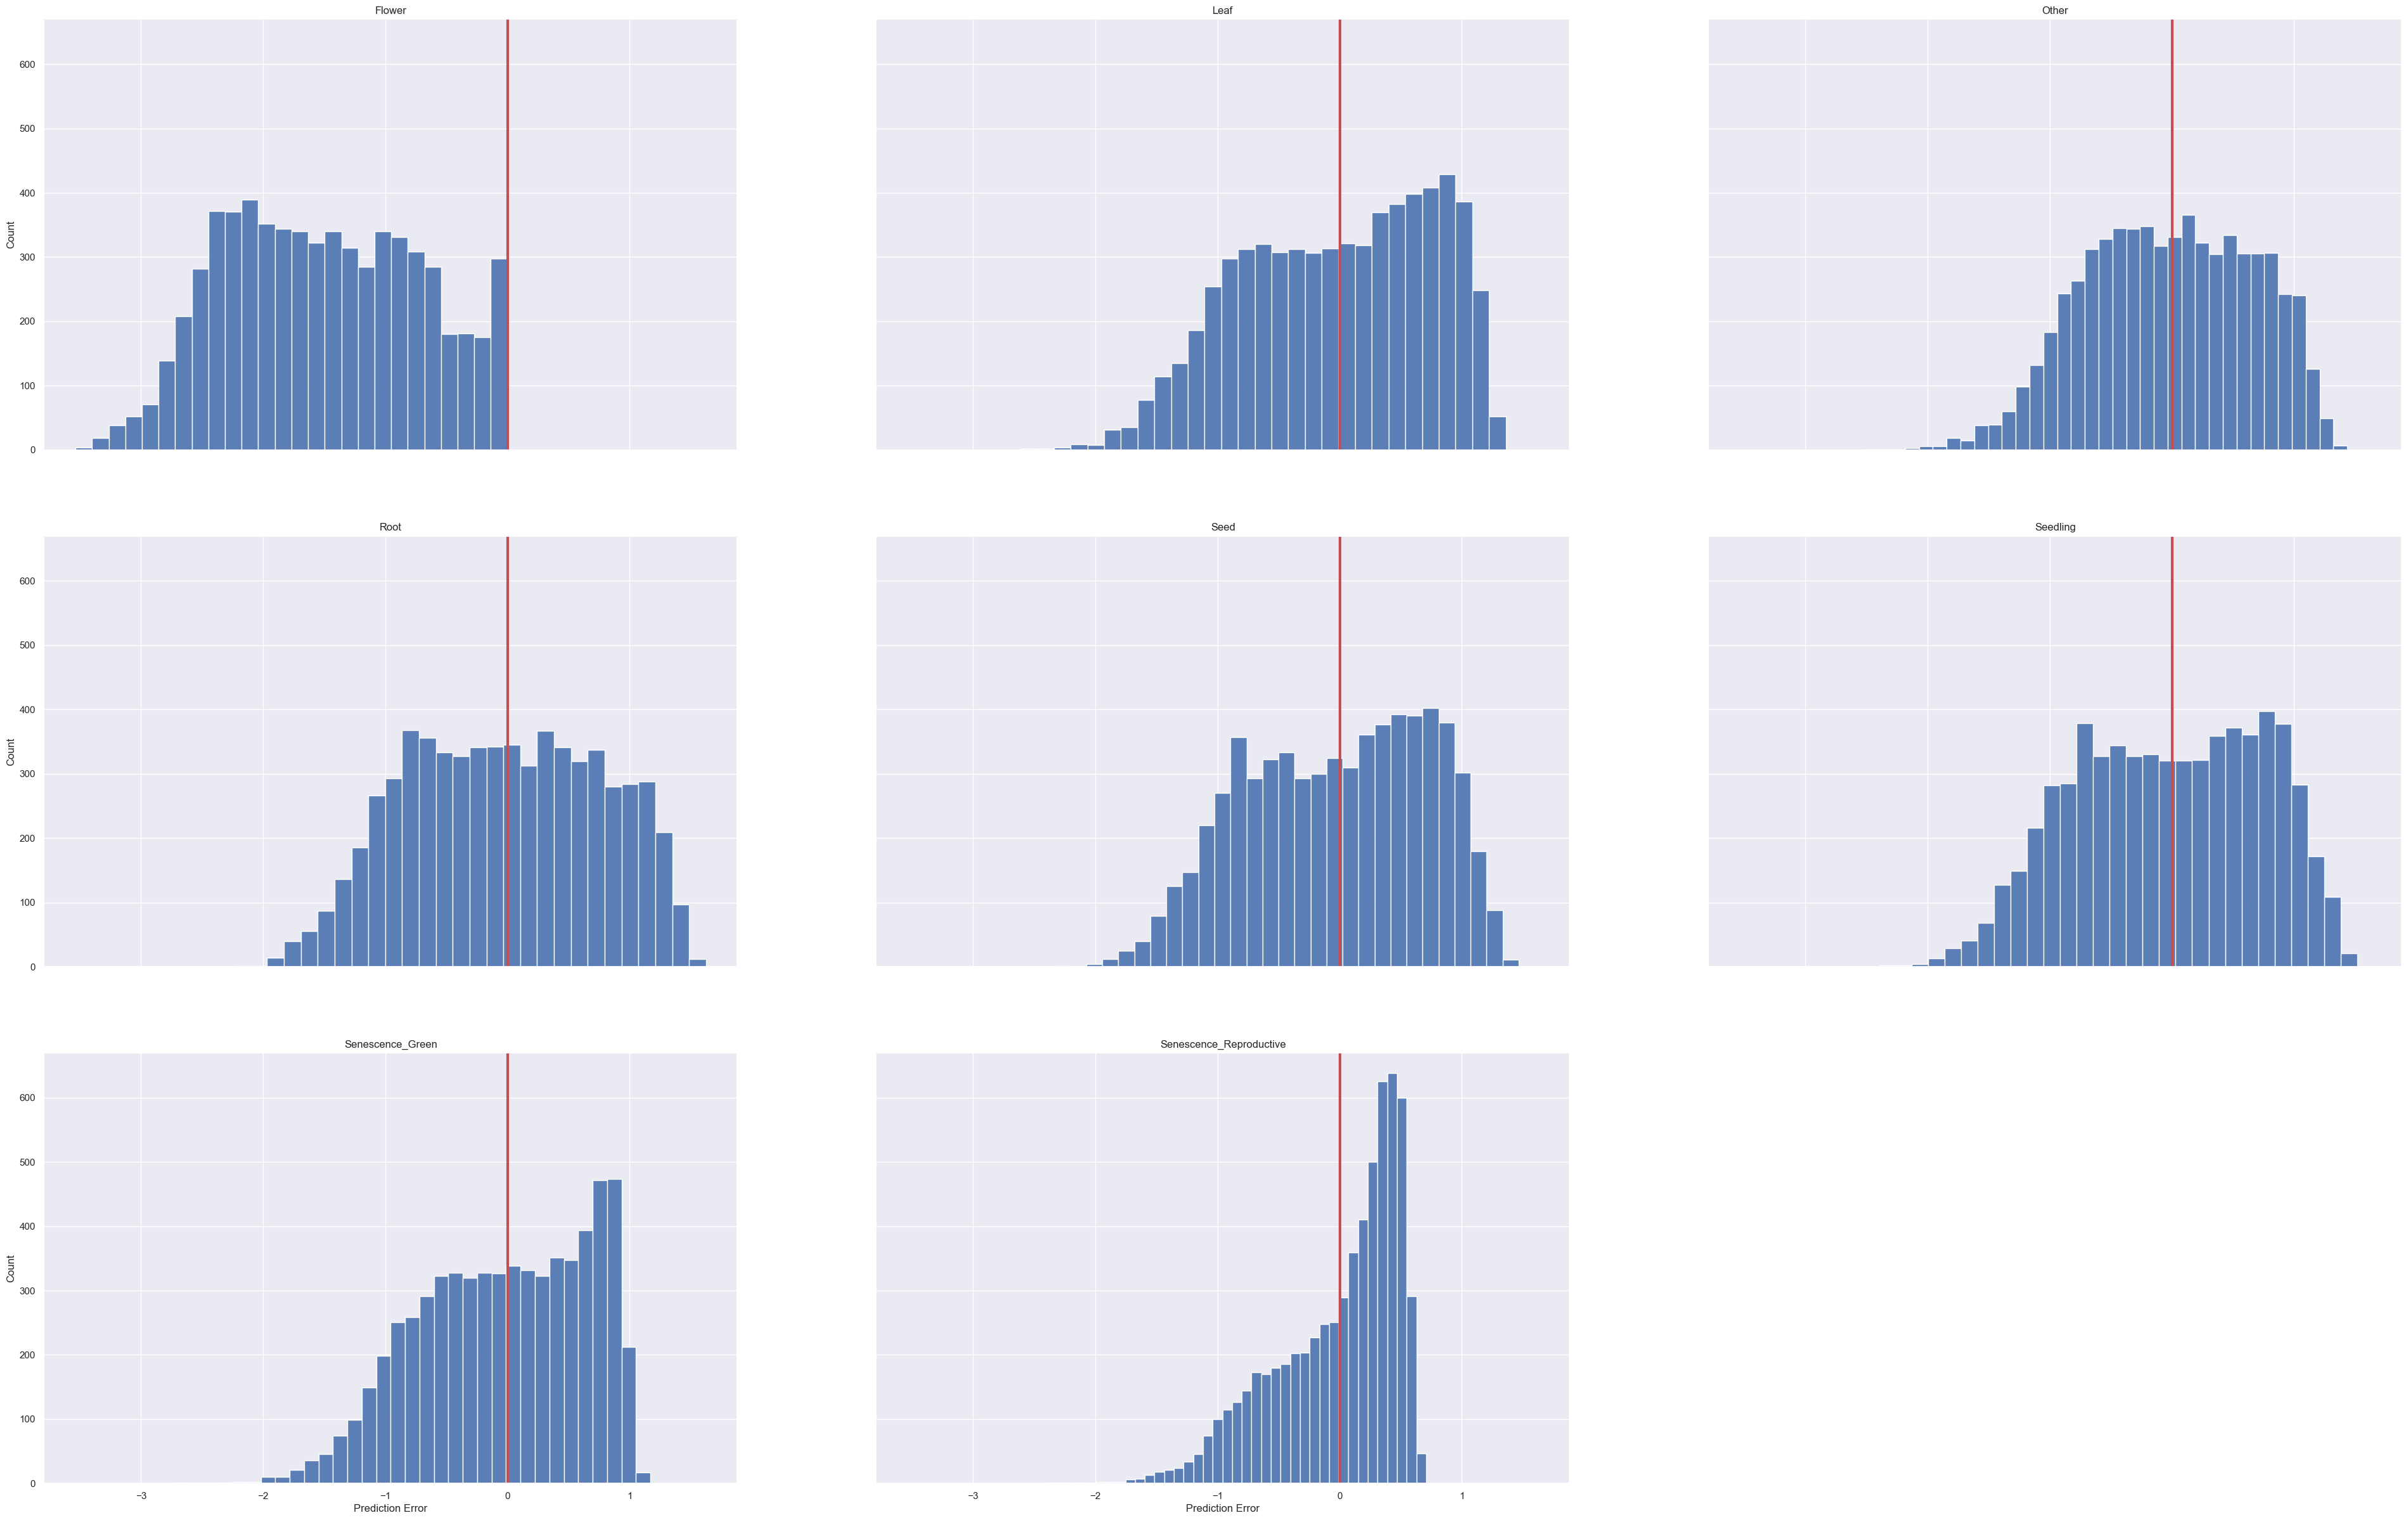

In [27]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

In [28]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

Variance in [flower] is almost zero (1.00e-07) : 0.00000000


In [29]:
# Display the evaluation accuracy

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy : 41.29972 %



,Group,Total,Count,Accuracy,Avg MAE,Std MAE
7,senescence_reproductive,6336,3837,60.559,0.414,0.286
6,senescence_green,6336,3825,60.369,0.577,0.360
2,other,6336,3388,53.472,0.572,0.372
4,seed,6336,2614,41.256,0.633,0.383
1,leaf,6336,2285,36.064,0.667,0.405
3,root,6336,2219,35.022,0.673,0.416
5,seedling,6336,2212,34.912,0.653,0.398
0,flower,6336,554,8.744,1.517,0.796


### 2.4.2 Best Model

In [30]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 6
Loss  : 0.81464


<All keys matched successfully>

In [31]:
# Evaluate the model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [32]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.44681
MAE Loss :  0.71771
MSE Loss :  0.81319


In [33]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT1G32370.4
True : [ 1.46468    1.06108    1.15446    1.38725    1.38526    1.26143    0.68642    0.25961]
Pred : [ 0.00000    1.32170    1.34367    1.53605    1.43799    1.47197    1.09298    0.70615]
 MAE : [ 1.46468    0.26062    0.18922    0.14881    0.05273    0.21054    0.40657    0.44654]
 MSE : [ 2.14530    0.06793    0.03580    0.02214    0.00278    0.04433    0.16530    0.19940]
 R2  : [-3.45820   -0.01876   -0.12265    0.02424    0.01488    0.00168   -0.02462    0.02826]

Gene : AT3G06290.4
True : [ 1.52182    1.01498    1.04755    1.28877    1.40015    1.08163    1.01044    0.91520]
Pred : [ 0.00000    1.19246    1.20793    1.38531    1.29035    1.32389    0.98480    0.63250]
 MAE : [ 1.52182    0.17748    0.16038    0.09654    0.10981    0.24227    0.02564    0.28270]
 MSE : [ 2.31594    0.03150    0.02572    0.00932    0.01206    0.05869    0.00066    0.07992]
 R2  : [-3.48980    0.04744    0.02901    0.02393    0.06850    0.03642    0.05440    0.04625]



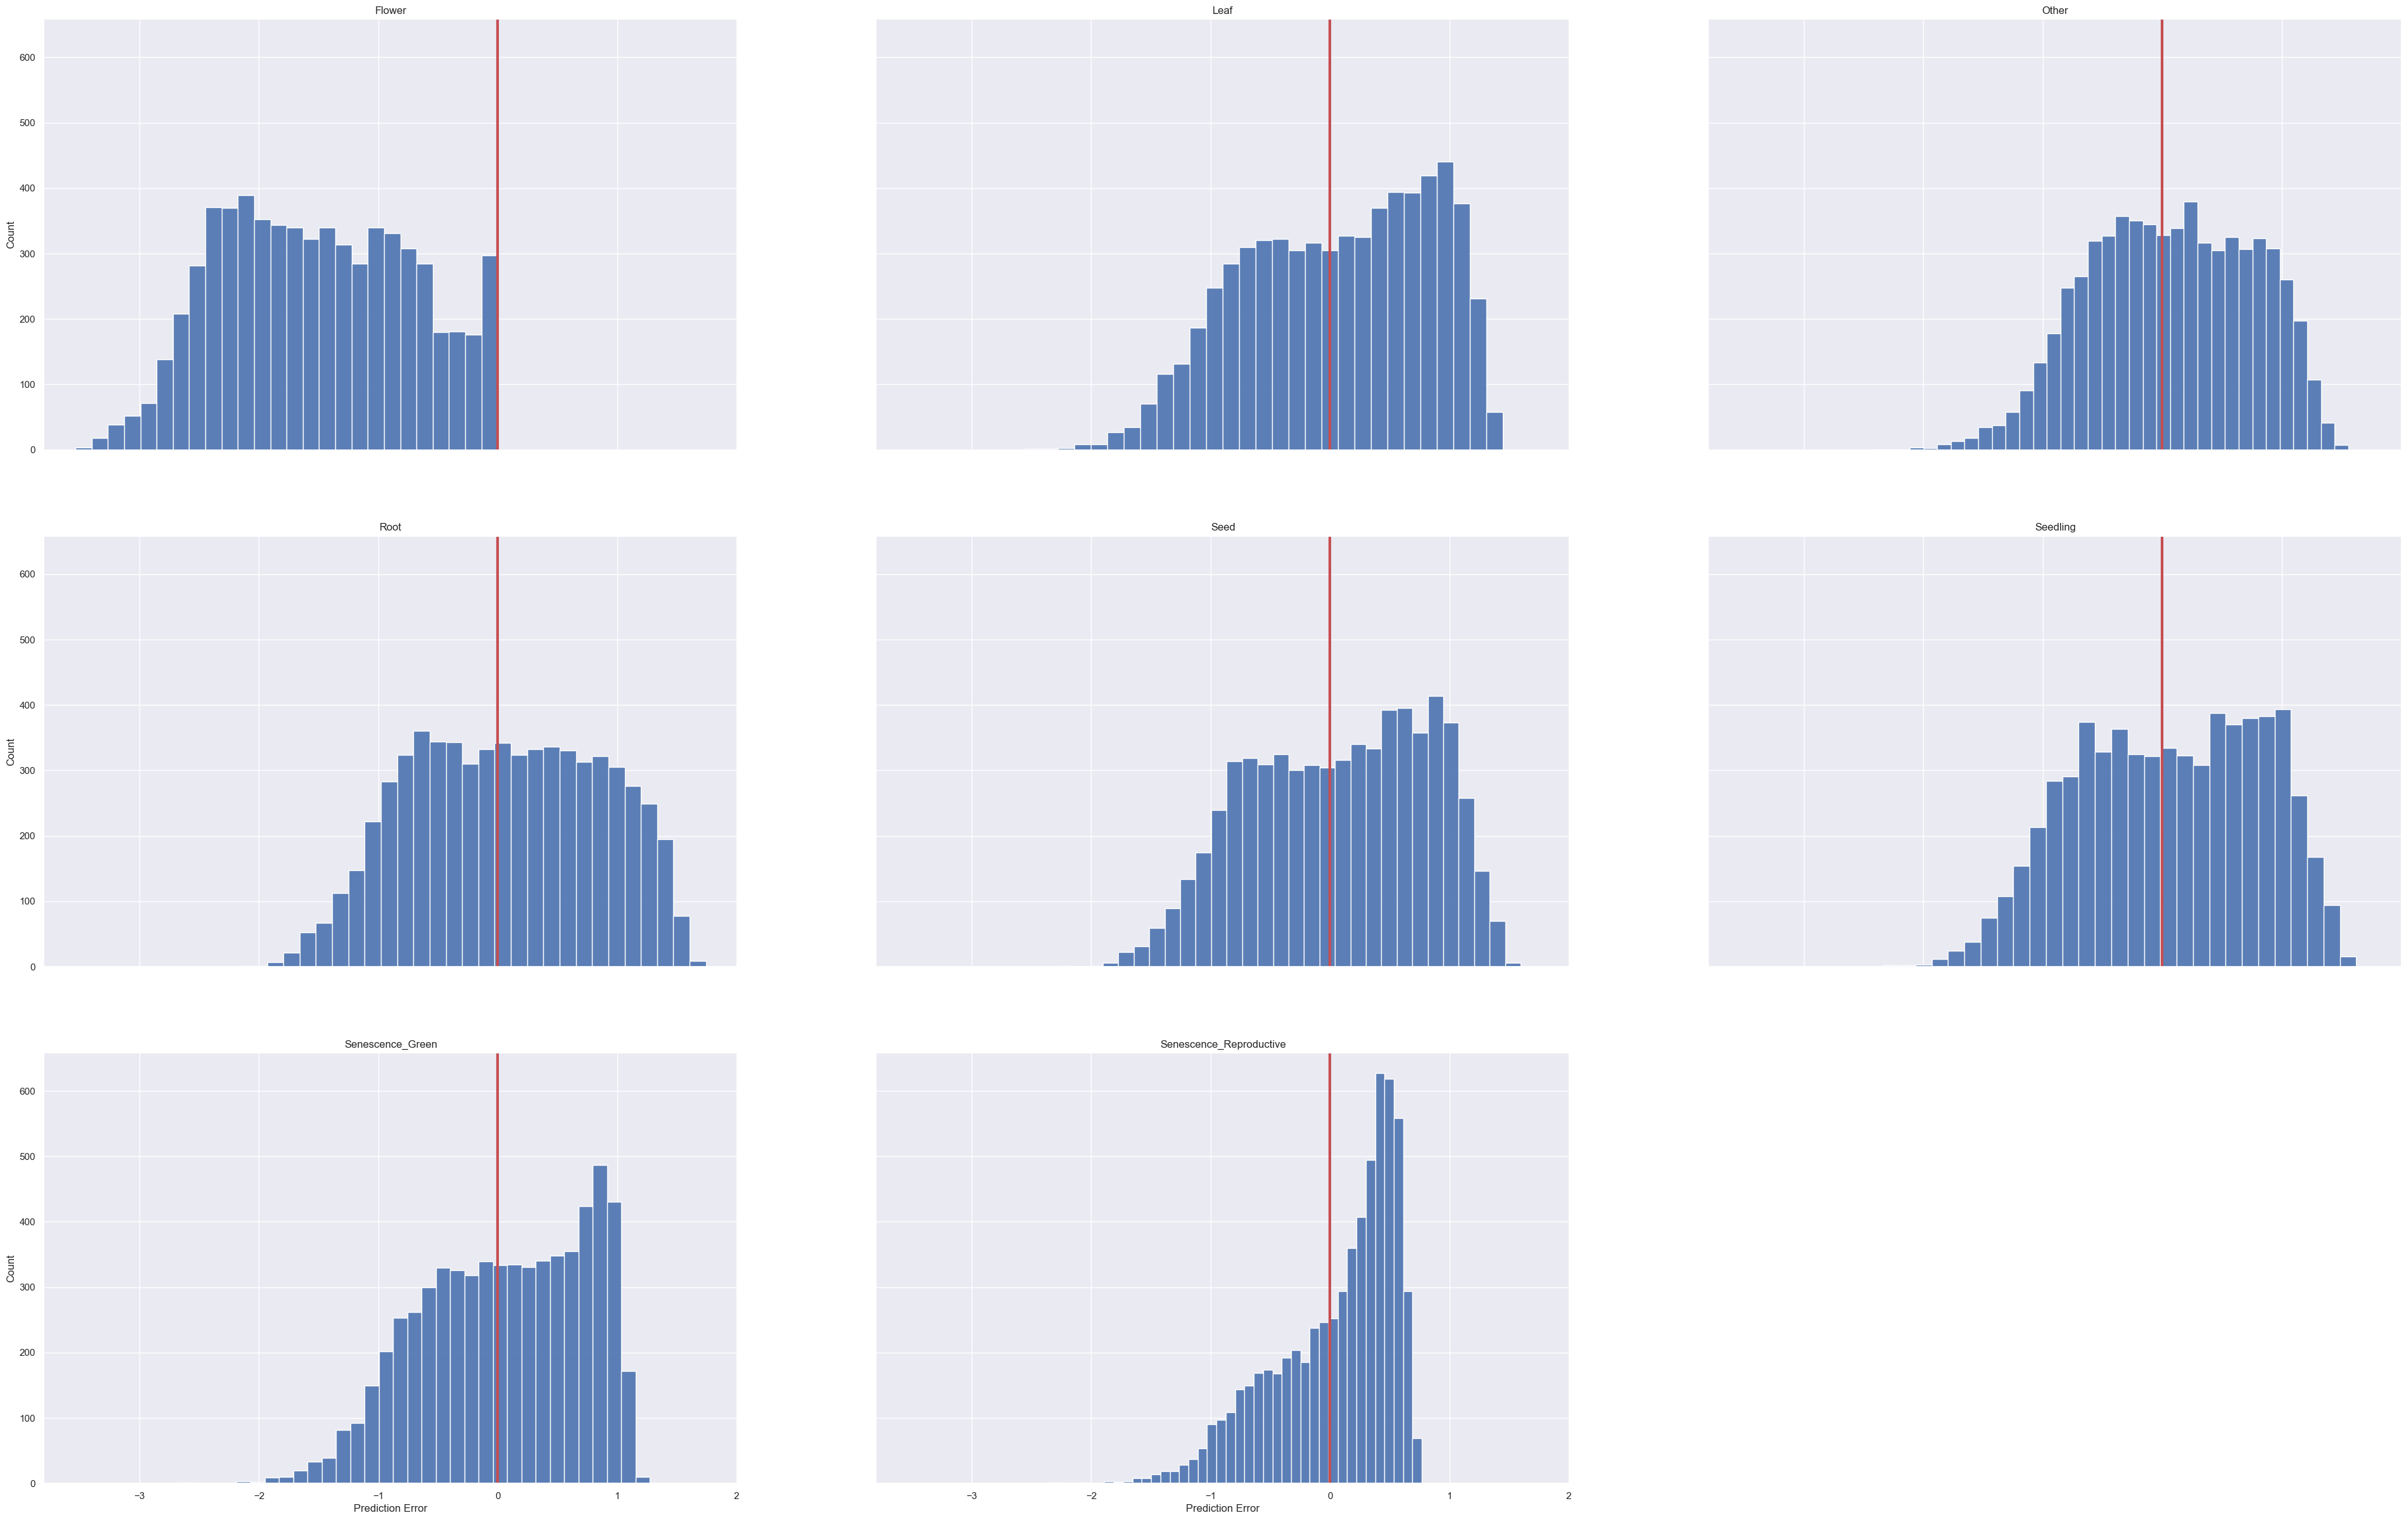

In [34]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

In [35]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

Variance in [flower] is almost zero (1.00e-07) : 0.00000000


In [36]:
# Display the evaluation accuracy

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy : 40.79269 %



,Group,Total,Count,Accuracy,Avg MAE,Std MAE
6,senescence_green,6336,3830,60.448,0.581,0.355
7,senescence_reproductive,6336,3697,58.349,0.428,0.270
2,other,6336,3400,53.662,0.574,0.374
4,seed,6336,2585,40.799,0.640,0.380
1,leaf,6336,2249,35.496,0.672,0.400
3,root,6336,2195,34.643,0.674,0.418
5,seedling,6336,2166,34.186,0.655,0.396
0,flower,6336,555,8.759,1.517,0.796
